## Task 1: Exploratory Data Analysis (EDA)

### Data Loading and Cleaning

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Check for missing values and data types
print(customers.info())
print(products.info())
print(transactions.info())

# Handle missing values if any (fill with mean or drop rows)
customers = customers.dropna()  # example: drop missing data
transactions = transactions.dropna()

# Remove duplicates if any
customers = customers.drop_duplicates()
transactions = transactions.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    

### Descriptive Statistics and Visualizations

                SignupDate
count                  200
mean   2023-07-19 08:31:12
min    2022-01-22 00:00:00
25%    2022-09-26 12:00:00
50%    2023-08-31 12:00:00
75%    2024-04-12 12:00:00
max    2024-12-28 00:00:00
            Price
count  100.000000
mean   267.551700
std    143.219383
min     16.080000
25%    147.767500
50%    292.875000
75%    397.090000
max    497.760000
                     TransactionDate     Quantity   TotalValue       Price
count                           1000  1000.000000  1000.000000  1000.00000
mean   2024-06-23 15:33:02.768999936     2.537000   689.995560   272.55407
min              2023-12-30 15:29:12     1.000000    16.080000    16.08000
25%       2024-03-25 22:05:34.500000     2.000000   295.295000   147.95000
50%       2024-06-26 17:21:52.500000     3.000000   588.880000   299.93000
75%              2024-09-19 14:19:57     4.000000  1011.660000   404.40000
max              2024-12-28 11:00:00     4.000000  1991.040000   497.76000
std                   

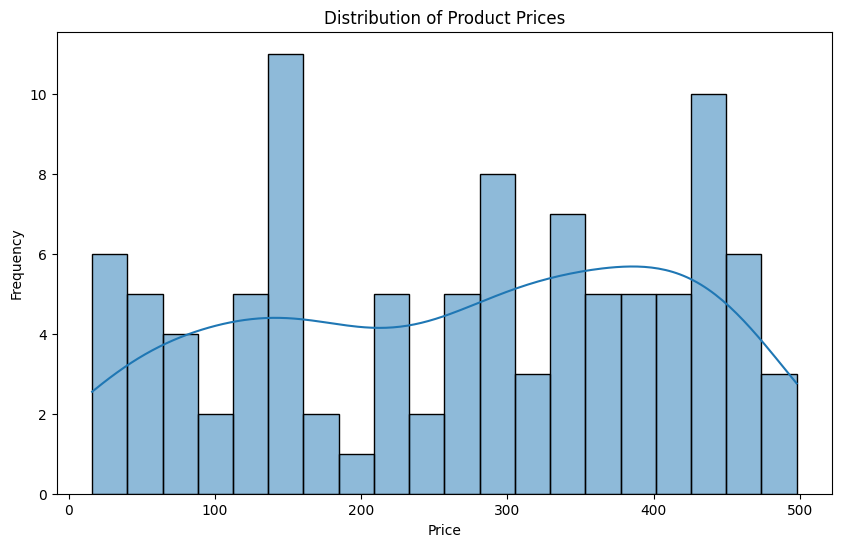

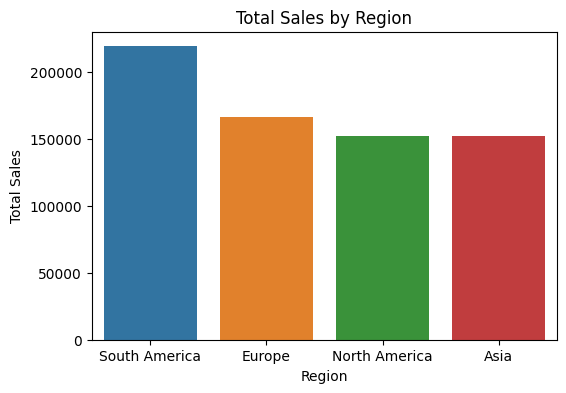

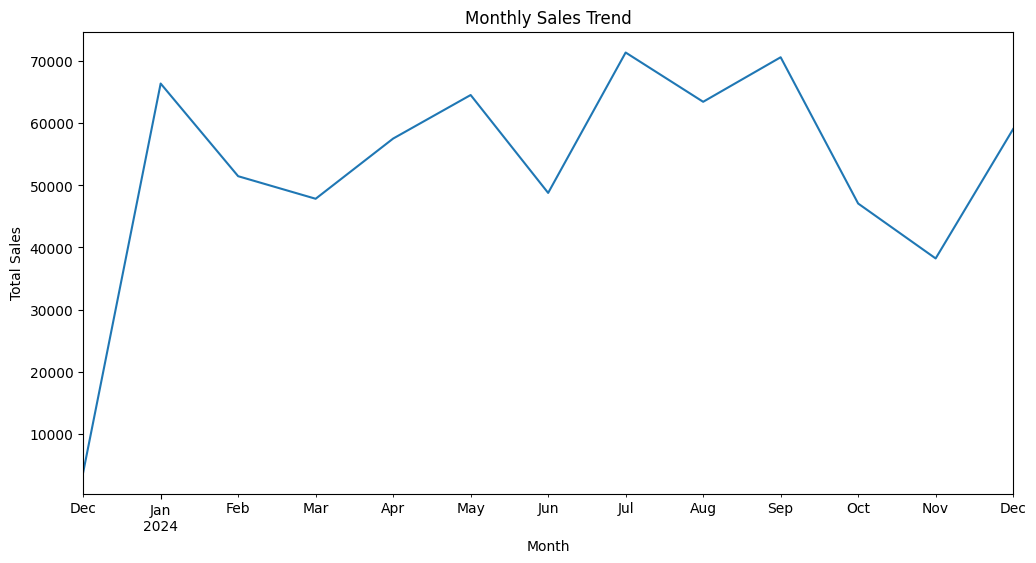

In [28]:
# Summary statistics for numeric columns
print(customers.describe())
print(products.describe())
print(transactions.describe())

# Distribution of product prices
plt.figure(figsize=(10, 6))
sns.histplot(products['Price'], bins=20, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Sales by region (bar plot)
merged_data = transactions.merge(customers[['CustomerID', 'Region']], on='CustomerID')

# Group by 'Region' and sum the 'TotalValue'
region_sales = merged_data.groupby('Region')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
sns.barplot(x=region_sales.index, y=region_sales.values)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.show()

# Time series analysis (sales over time)
transactions['YearMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('YearMonth')['TotalValue'].sum()
monthly_sales.plot(figsize=(12, 6))
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

## Task 2: Lookalike Model

### Data Preparation

In [29]:
# Merge transactions with customer data to get customer profile
customer_transactions = transactions.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# Merge with customer info
customer_data = pd.merge(customers[['CustomerID', 'Region']], customer_transactions, on='CustomerID')

# Example: Add product categories purchased by each customer
customer_data['product_categories'] = transactions.groupby('CustomerID')['ProductID'].apply(
    lambda x: products[products['ProductID'].isin(x)]['Category'].unique().tolist())

### Similarity Calculation (Cosine Similarity or Euclidean Distance)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Example: Standardize the data (total spent, transaction count, and number of categories)
scaler = StandardScaler()
features = customer_data[['total_spent', 'transaction_count']]
customer_data_scaled = scaler.fit_transform(features)

# Compute similarity between customers
similarity_matrix = cosine_similarity(customer_data_scaled)

# Example function to get top 3 similar customers
def get_top_similar_customers(customer_id, top_n=3):
    similarity_scores = similarity_matrix[customer_id]
    similar_customer_ids = similarity_scores.argsort()[-top_n-1:-1]  # excluding self
    return [(customer_data['CustomerID'].iloc[i], similarity_scores[i]) for i in similar_customer_ids]

# Get top 3 lookalikes for the first 20 customers
lookalikes = {}
for i in range(20):
    lookalikes[customer_data['CustomerID'].iloc[i]] = get_top_similar_customers(i)

# Save lookalikes to CSV
lookalike_df = pd.DataFrame(lookalikes).T
lookalike_df.to_csv('Lookalike.csv')

## Task 3 : Customer Segmentation/Clustering

Davies-Bouldin Index: 0.6375161720046076


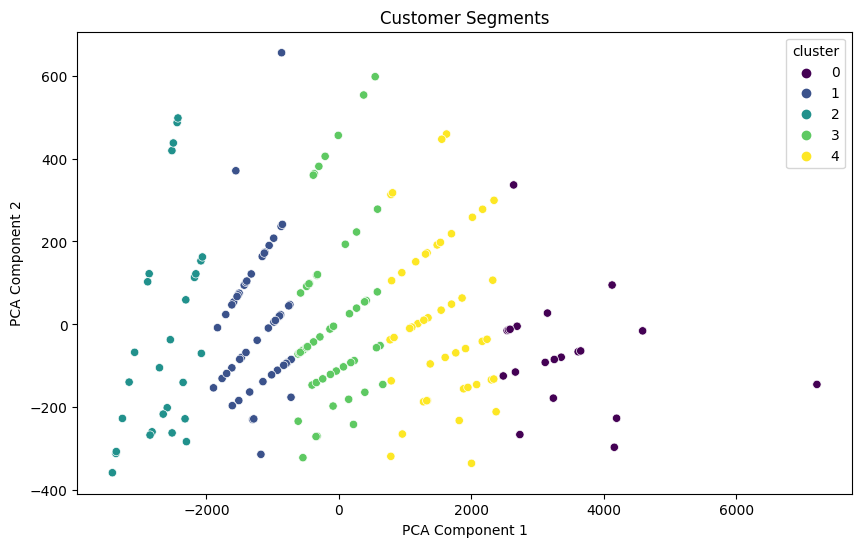

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

# Safely apply len() to non-float iterable elements in 'product_categories'
customer_data['category_count'] = customer_data['product_categories'].apply(
    lambda x: len(x) if isinstance(x, (list, str)) else 0)


# Select features for clustering
X = customer_data[['total_spent', 'transaction_count', 'avg_purchase_value', 'category_count']]

# Perform clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(X)

# Calculate the Davies-Bouldin Index (DB Index) to evaluate clustering quality
db_index = davies_bouldin_score(X, customer_data['cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualizing clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

### Evaluation Metrics

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(X, customer_data['cluster'])
print(f'Silhouette Score: {sil_score}')